A little over eight years ago, I published a [post](https://austinrochford.com/posts/2017-07-09-mrpymc3.html) entitled _MRPyMC3 - Multilevel Regression and Poststratification with PyMC3_, showing how to perform [multilevel regression with poststratification](https://en.wikipedia.org/wiki/Multilevel_regression_with_poststratification) (MRP) in Python with PyMC. I periodically enjoy [revisiting](https://austinrochford.com/posts/revisit-survival-pymc.html) old posts after both technology and my understanding of the problem advances.  This post revisits MRP with a few notable changes:

* [PyMC](http://pymc.io/) is now on major version 5 instead of version 3,
* we use [nutpie](https://pymc-devs.github.io/nutpie/) for sampling from the model instead of PyMC's built in sampler, and
* we use [Polars](http://pymc.io/) instead of [pandas](https://pandas.pydata.org/).

We will not repeat the previous post's full exposition of MRP and will rather focus on the mechanics of its implementation.

First we import the necessary packages and do a bit of light configuration.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
from itertools import zip_longest
import os
from urllib import request
import us
from zipfile import ZipFile

In [3]:
import arviz as az
from matplotlib import cm, pyplot as plt, ticker
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
import numpy as np
import nutpie
import polars as pl
import pymc as pm
from pyreadstat import read_dta
from pytensor import tensor as pt
import seaborn as sns
from seaborn import objects as so
from scipy.special import logit

In [4]:
sns.set_style("darkgrid", {"axes.linewidth": 1, "axes.edgecolor": "black"})

## Load and transform the data

As in the previous post, we follow [Jonathan Kastellec](https://jkastellec.scholar.princeton.edu/)'s excellent [MRP Primer](https://jkastellec.scholar.princeton.edu/publications/mrp_primer), which focuses on estimating state-level opinions of gay marriage in 2005/2006 from polling data.

First we download and decompress the data.

In [5]:
DATA_PATH = "./data"
DATA_URI = "https://jkastellec.scholar.princeton.edu/sites/g/files/toruqf3871/files/jkastellec/files/mrp_primer_replication_files.zip"

In [6]:
USER_AGENT = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36"

In [7]:
if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)

dest_path = os.path.join(DATA_PATH, os.path.basename(DATA_URI))

if not os.path.exists(dest_path):
    opener = request.build_opener()
    opener.addheaders = [("User-agent", USER_AGENT)]
    request.install_opener(opener)
    request.urlretrieve(DATA_URI, dest_path)

    with ZipFile(dest_path) as src:
        src.extractall(DATA_PATH)

### Poll data

Next we load and do some light feature engineering on the polling data necessary to build the multilevel model.

In [8]:
UNZIPPED_DIR = "MRP_Primer_Replication_Files"

In [9]:
POLL_PATH = os.path.join(DATA_PATH, UNZIPPED_DIR, "gay_marriage_megapoll.dta")

In [10]:
POLL_COLS = [
    "race_wbh",
    "age_cat",
    "edu_cat",
    "female",
    "region",
    "state",
    "poll",
    "yes_of_all",
]

NN_COLS = ["race_wbh", "age_cat", "edu_cat"]

In [11]:
def to_zero_indexed(name):
    col = pl.col(name)

    return col - col.min()

In [12]:
CAT_COLS = ["age_cat", "edu_cat", "race_wbh"]

cat_col_transforms = [to_zero_indexed(name) for name in CAT_COLS]

In [13]:
GENDER = pl.Enum(["Male", "Female"])
POLL = pl.Enum(
    [
        "ABC 2004Jan15",
        "Gall2004Mar05",
        "Gall2005Aug22",
        "Pew 2004Dec01",
        "Pew 2004Feb11",
    ]
)
RACE = pl.Enum(["White", "Black", "Hispanic"])
REGION = pl.Enum(["dc", "midwest", "northeast", "south", "west"])
STATE = pl.Enum(sorted([state.abbr for state in us.states.STATES] + ["DC"]))

In [14]:
ENUM_CASTS = {
    "female": (GENDER, "gender"),
    "poll": (POLL, None),
    "race_wbh": (RACE, "race"),
    "region": (REGION, None),
    "state": (STATE, None),
}


def cast_enum_cols(df):
    for name, (enum, new_name) in ENUM_CASTS.items():
        if name in df.columns:
            df = df.with_columns(pl.col(name).cast(enum).alias(new_name or name))

            if new_name is not None:
                df = df.drop(name)

    return df

In [15]:
poll_df = (
    pl.from_pandas(read_dta(POLL_PATH)[0])
    .select(POLL_COLS)
    .drop_nulls(NN_COLS)
    .with_columns(*cat_col_transforms)
    .group_by(POLL_COLS[:-1])
    .agg(pl.sum("yes_of_all"), poll_pop=pl.len().cast(pl.Int32))
    .filter(pl.col("state") != "")
    .pipe(cast_enum_cols)
)

In [16]:
poll_df

age_cat,edu_cat,region,state,poll,yes_of_all,poll_pop,gender,race
i64,i64,enum,enum,enum,i64,i32,enum,enum
1,1,"""south""","""DE""","""Gall2005Aug22""",0,1,"""Male""","""Black"""
3,3,"""south""","""FL""","""Pew 2004Dec01""",3,5,"""Male""","""White"""
0,3,"""south""","""VA""","""Pew 2004Feb11""",1,1,"""Female""","""White"""
0,1,"""midwest""","""OH""","""Gall2004Mar05""",0,1,"""Male""","""White"""
3,1,"""south""","""TN""","""ABC 2004Jan15""",0,1,"""Male""","""Black"""
…,…,…,…,…,…,…,…,…
3,1,"""west""","""CA""","""Pew 2004Feb11""",0,1,"""Female""","""Black"""
1,3,"""midwest""","""IA""","""ABC 2004Jan15""",1,1,"""Female""","""White"""
0,3,"""south""","""TN""","""Pew 2004Feb11""",1,1,"""Female""","""White"""


Each row represents a group of people polled:

* `age_cat` represents the age category of that group,
* `edu_cat` represents the education category of that group,
* `region` represents the region of the state in which that group resides,
* `state` represents the state in which that group resides,
* `poll` represents which poll surveyed that group,
* `yes_of_all` represents the number of respondents that indicated support for gay marriage,
* `poll_pop` represents the number of respondents,
* `gender` represents the gender of that group, and
* `race` represents the race of that group.

### Census data

Next we load and do some light feature engineering on the census data necessary for postratification.

In [17]:
CENSUS_PATH = os.path.join(DATA_PATH, UNZIPPED_DIR, "poststratification 2000.dta")

In [18]:
CENSUS_COLS = [
    "race_wbh",
    "age_cat",
    "edu_cat",
    "female",
    "state",
    "_freq",
    "region",
]

In [19]:
census_df = (
    pl.from_pandas(read_dta(CENSUS_PATH)[0])
    .rename(lambda s: s.lstrip("c").lower())
    .select(CENSUS_COLS)
    .rename({"_freq": "pop"})
    .with_columns(*cat_col_transforms)
    .pipe(cast_enum_cols)
    .sort("state")
)

In [20]:
census_df

age_cat,edu_cat,state,pop,region,gender,race
i64,i64,enum,i64,enum,enum,enum
0,0,"""AK""",467,"""west""","""Male""","""White"""
1,0,"""AK""",377,"""west""","""Male""","""White"""
2,0,"""AK""",419,"""west""","""Male""","""White"""
3,0,"""AK""",343,"""west""","""Male""","""White"""
0,1,"""AK""",958,"""west""","""Male""","""White"""
…,…,…,…,…,…,…
3,2,"""WY""",4,"""west""","""Female""","""Hispanic"""
0,3,"""WY""",8,"""west""","""Female""","""Hispanic"""
1,3,"""WY""",16,"""west""","""Female""","""Hispanic"""


Each row represents a group of people with the given age, education, state, gender, and race combination.  All columns have the same meaning as in the poll data.  The `pop` column contains the census population of that group.

### State data

Finally, we load and do some light feature engineering on data about each state, which we will use, in addition to the poll data, to build our multilevel model.

In [21]:
STATE_PATH = os.path.join(DATA_PATH, UNZIPPED_DIR, "state_level_update.dta")

In [22]:
STATE_COLS = ["sstate", "p_evang", "p_mormon", "kerry_04"]

In [23]:
def to_percentage(name):
    return pl.col(name) / 100

In [24]:
state_df = (
    pl.from_pandas(read_dta(STATE_PATH)[0])
    .select(STATE_COLS)
    .rename(lambda name: name.replace("ss", "s"))
    .with_columns(
        to_percentage("p_evang"), to_percentage("p_mormon"), to_percentage("kerry_04")
    )
    .with_columns(p_relig=pl.col("p_evang") + pl.col("p_mormon"))
    .drop("p_evang", "p_mormon")
    .pipe(cast_enum_cols)
    .join(census_df.group_by("state").agg(pl.first("region")), on="state")
    .sort("state")
)

In [25]:
state_df

state,kerry_04,p_relig,region
enum,f64,f64,enum
"""AK""",0.355,0.154431,"""west"""
"""AL""",0.368,0.410083,"""south"""
"""AR""",0.446,0.436301,"""south"""
"""AZ""",0.444,0.142887,"""west"""
"""CA""",0.543,0.087176,"""west"""
…,…,…,…
"""VT""",0.589,0.02912,"""northeast"""
"""WA""",0.528,0.128227,"""west"""
"""WI""",0.497,0.129527,"""midwest"""


There is a row for each state, plus an additional one for the District of Columbia, with the following columns:
* `state` - the state represented by that row,
* `kerry_04` - the proportion of the state's voters that voted for John Kerry in the 2004 presidential election,
* `p_relig` - the proportion of the state's population that identifies as evangelical Christian or Mormon, and
* `region` - the region of the country the state is in.

## Exploratory data analysis

Now that we have all the necessary data, we visualize it in order to become familiar with it before building the model.

First we define a few functions that will facilitate intuitive plotting of state-level statistics.

In [26]:
STATE_GRID = [
    ["AK", None, None, None, None, None, None, None, None, None, "ME"],
    [None, None, None, None, None, None, None, None, None, "VT", "NH"],
    ["WA", "ID", "MT", "ND", "MN", None, "MI", None, "NY", "MA", "RI"],
    ["OR", "UT", "WY", "ND", "IA", "WI", "OH", "PA", "NJ", "CT"],
    ["CA", "NV", "CO", "NE", "IL", "IN", "WV", "VA", "MD", "DE"],
    [None, "AZ", "NM", "KS", "MO", "KY", "TN", "SC", "NC"],
    [None, None, None, "OK", "LA", "AR", "MS", "AL", "GA", None, "DC"],
    ["HI", None, None, None, "TX", None, None, None, "FL"],
]

In [27]:
def plot_facecolor(df, col, state, *, ax, norm, cmap, default="gray"):
    is_state = pl.col("state") == state

    if df.select(is_state.any()).item():
        color = cmap(norm(df.filter(is_state)[col]))
    else:
        color = default

    ax.set_facecolor(color)

In [28]:
def plot_state_grid(
    data, *, col, norm, cmap, default="gray", cbar=True, ax_plotter=plot_facecolor
):
    nrows = len(STATE_GRID)
    ncols = max(len(row) for row in STATE_GRID)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    for state_row, ax_row in zip(STATE_GRID, axes):
        for state, ax in zip_longest(state_row, ax_row):
            if state is None:
                ax.axis("off")
            else:
                ax.set_xticks([])
                ax.set_yticks([])

                ax.annotate(state, xy=(0.1, 0.1), xycoords="axes fraction")

                ax_plotter(
                    data, col, state, ax=ax, norm=norm, cmap=cmap, default=default
                )

    if cbar:
        cbar_ax = fig.add_axes([0.925, 0.25, 0.02, 0.5])
        ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    else:
        cbar_ax = None

    return fig, axes, cbar_ax

### Poll data

With the data and these tools in hand, we begin by plotting the number of poll respondents in each state.

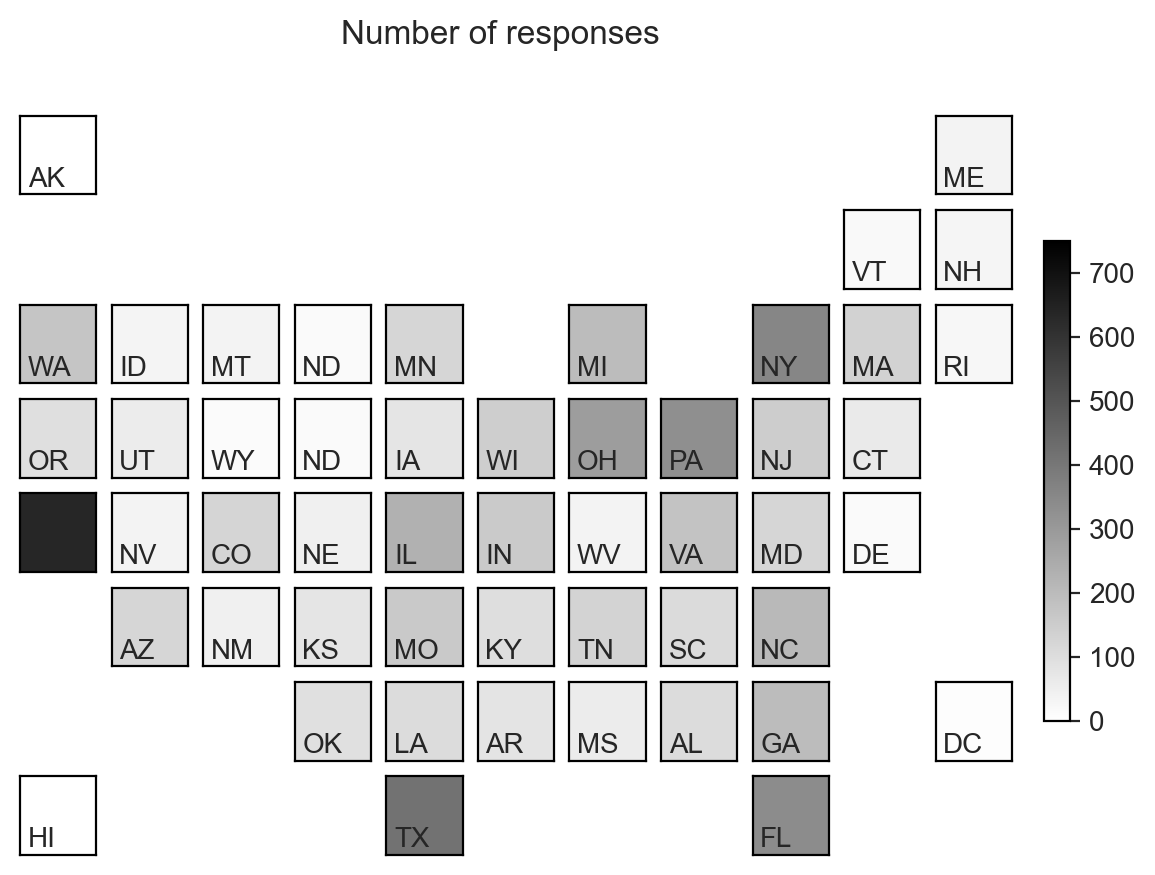

In [29]:
fig, _, _ = plot_state_grid(
    poll_df.group_by("state").agg(pl.sum("poll_pop")),
    col="poll_pop",
    norm=Normalize(0, 750),
    cmap=cm.binary,
    default="white",
)

fig.suptitle("Number of responses");

We see immediately that some states have very few respondents, and indeed that Alaska and Hawaii had no respondents.

In [30]:
(
    poll_df.group_by("state")
    .agg(pl.sum("poll_pop"))
    .join(state_df, how="right", on="state")
    .with_columns(pl.col("poll_pop").fill_null(0))
    .sort("poll_pop")
    .select("state", "poll_pop")
    .head()
)

state,poll_pop
enum,i32
"""AK""",0
"""HI""",0
"""DC""",6
"""WY""",14
"""DE""",16


One of the benefits of MRP is the ability to use census data to predict the support for gay marriage in these states with little to no data based on similar respondents in other states.

Next we visualize the empirical support for gay marriage in each state.

In [31]:
PROB_CMAP = sns.diverging_palette(220, 10, as_cmap=True).reversed()
PROB_FORMATTER = ticker.StrMethodFormatter("{x:.1%}")
PROB_LOCATOR = ticker.MultipleLocator(0.2)
PROB_MIN, PROB_MAX = 0.1, 0.70
PROB_NORM = Normalize(0, PROB_MAX)

In [32]:
def make_prob_ax(ax):
    cbar_ax.yaxis.set_major_locator(PROB_LOCATOR)
    cbar_ax.yaxis.set_major_formatter(PROB_FORMATTER)

In [33]:
def rate(num, denom):
    return pl.sum(num) / pl.sum(denom)

In [34]:
disagg_df = poll_df.group_by("state").agg(rate("yes_of_all", "poll_pop"))

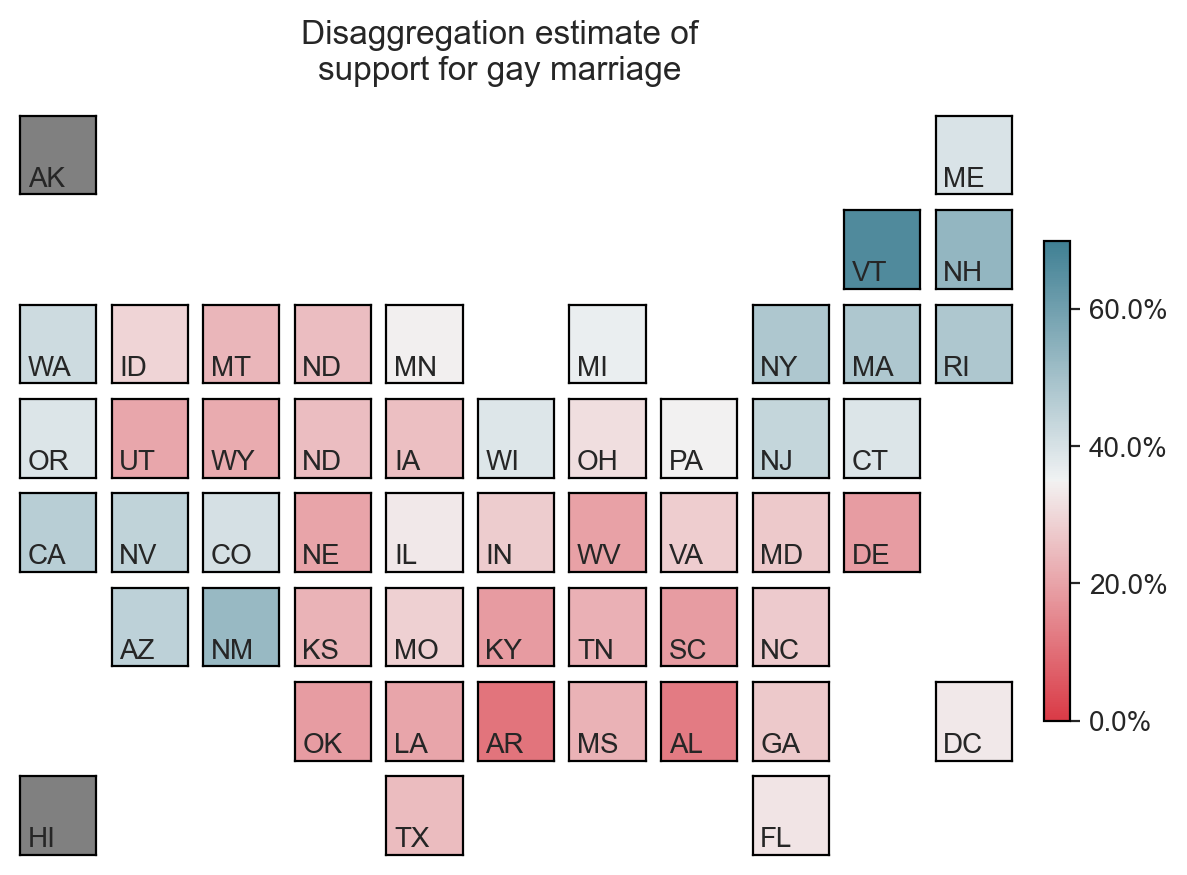

In [35]:
fig, _, cbar_ax = plot_state_grid(
    disagg_df,
    col="yes_of_all",
    norm=PROB_NORM,
    cmap=PROB_CMAP,
)

make_prob_ax(cbar_ax)
fig.suptitle("Disaggregation estimate of\nsupport for gay marriage");

Note that the MRP literature, including the Kastellec primer we are following in this post, refer to this quantity as the "disaggregation estimate."  We will use that language throughout the rest of this post for consistency.  At the end of the post we will see how the MRP estimates of support for gay marriage differ from these disaggregation estimates.  The difference between these estimates is largely due to the fact that the polled population is not (and cannot practically be) precisely reflective of the population of each state.

This challenge of representative sampling is further illustrated in the following plot.

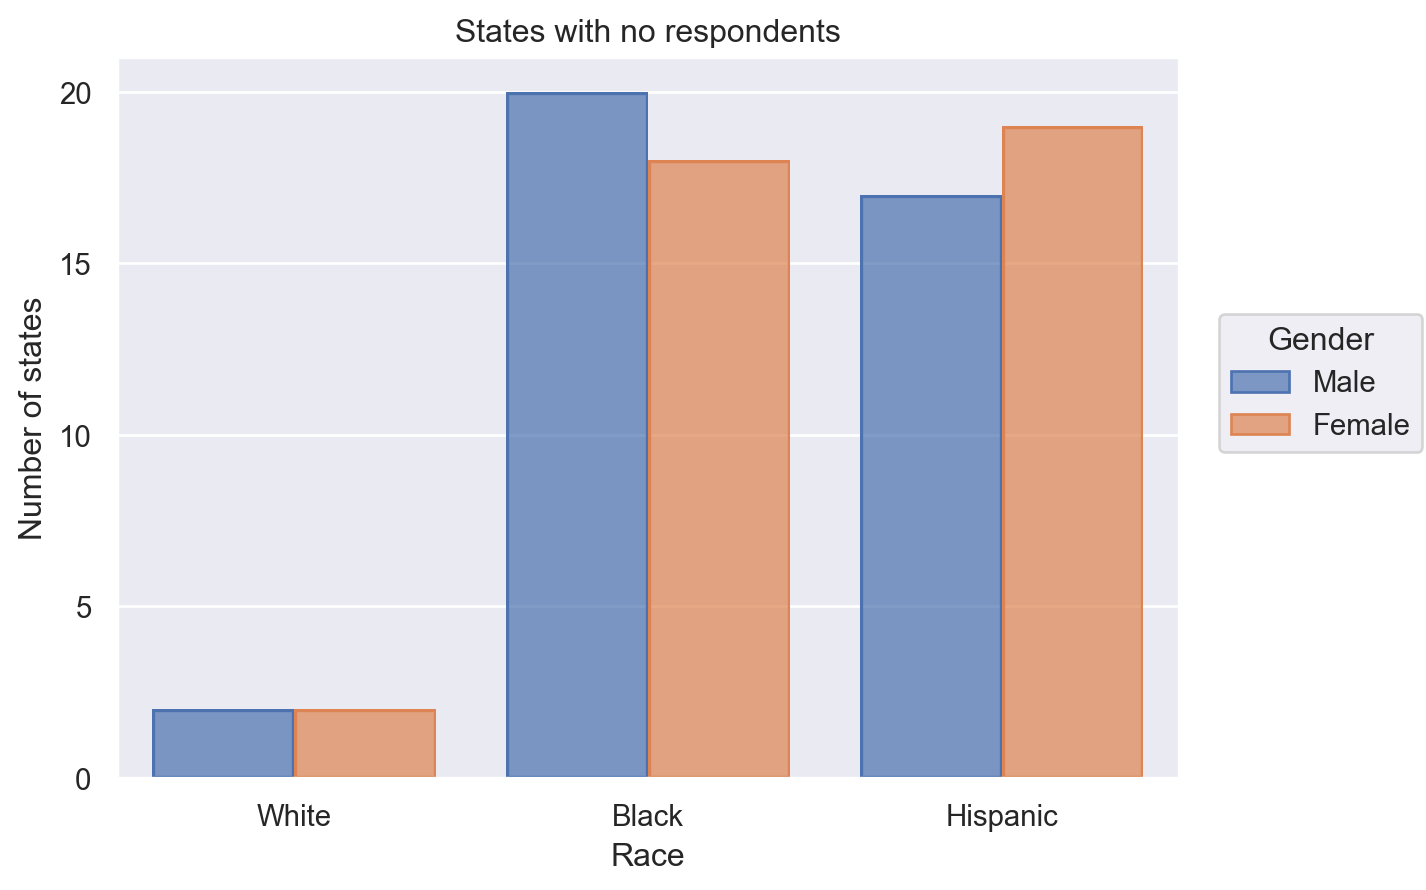

In [36]:
(
    so.Plot(
        poll_df.join(
            census_df, on=set(poll_df.columns) & set(census_df.columns), how="right"
        )
        .group_by("state", "gender", "race")
        .agg(pl.col("poll_pop").fill_null(0).sum() == 0)
        .group_by("gender", "race")
        .agg(pl.sum("poll_pop").alias("state_ct")),
        x="race",
        y="state_ct",
        color="gender",
    )
    .add(so.Bar(), so.Dodge())
    .scale(y=so.Continuous().tick(every=5))
    .label(
        x="Race",
        y="Number of states",
        color="Gender",
        title="States with no respondents",
    )
)

While only two states have zero polled respondents, significantly more states have zero respondents from minority race/gender subpopulations.  As in states with zero respondents, a benefit of MRP is the ability to predict support for gay marriage among unsampled subpopulations in these states based on attitudes from similar respondents in other statse.

## Modeling

With this basic understanding, we now turn to building the multilevel model necessary for MRP.

First we define coordinates that will make our model easier to work with.

In [37]:
n_age = poll_df["age_cat"].n_unique()
n_edu = poll_df["edu_cat"].n_unique()

In [38]:
COORDS = {
    "age": np.arange(n_age),
    "edu": np.arange(n_edu),
    "gender": GENDER.categories.to_numpy(),
    "poll": POLL.categories.to_numpy(),
    "race": RACE.categories.to_numpy(),
    "region": REGION.categories.to_numpy(),
    "state": STATE.categories.to_numpy(),
}

The model includes an intercept with a normal prior,

$$\beta_0 \sim N(0, 2.5^2).$$

In [39]:
with pm.Model(coords=COORDS) as model:
    β0 = pm.Normal("β0", 0, 2.5)

Most of the terms of the model will be [hierarchical](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling) normal.  For example, the prior for the age effect is

$$
\begin{align}
    \sigma_{\text{age}}
        & \sim \text{Half-}N(2.5^2), \\
    \beta_{\text{age}}
        & \sim N(0, \sigma_{\text{age}}^2).
\end{align}
$$

For sampling efficiency, we actually use an equivalent [noncentered parameterization](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) of the above priors.  The priors for the effects of education, poll, age-education interaction, and gender-race interaction are defined similarly.

In [40]:
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

In [41]:
def noncentered_normal(name, *, dims, μ=0):
    Δ = pm.Normal(f"Δ_{name}", 0, 1, dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5 * HALFNORMAL_SCALE)

    return pm.Deterministic(name, μ + Δ * σ, dims=dims)

In [42]:
with model:
    β_age = noncentered_normal("β_age", dims="age")
    β_edu = noncentered_normal("β_edu", dims="edu")
    β_poll = noncentered_normal("β_poll", dims="poll")

    β_age_edu = noncentered_normal("β_age_edu", dims=("age", "edu"))
    β_gender_race = noncentered_normal("β_gender_race", dims=("gender", "race"))

The state-level effects are slightly more complex, combining a hierarchical normal region-level effect with the effect of the proportion of its residents that identify as religious and that of the state's support for John Kerry in 2024, .  We have

$$
\begin{align}
    \sigma_{\text{region}}
        & \sim \text{Half-}N(2.5^2), \\
    \alpha_{\text{region}}
        & \sim N(0, \sigma_{\text{region}}^2) \\
    \alpha_{\text{relig}}, \alpha_{\text{kerry}}
        & \sim N(0, 2.5^2), \\
    \beta_{\text{state}}
        & = \alpha_{\text{region}} + \alpha_{\text{relig}} \cdot x_{\text{relig}} +  \alpha_{\text{kerry}} \cdot x_{\text{kerry}}.
\end{align}
$$

Here $x_{\text{relig}}$ is the proportion of the state's residents that identify as religious and $x_{\text{kerry}}$ is the proportion that voted for John Kerry in 2024.

In [43]:
kerry_04 = state_df["kerry_04"].to_numpy()
p_relig = state_df["p_relig"].to_numpy()
state_region = state_df["region"].cast(pl.Categorical).to_physical().to_numpy()

In [44]:
with model:
    α_region = noncentered_normal("α_region", dims="region")
    α_relig = pm.Normal("α_relig", 0, 2.5)
    α_kerry = pm.Normal("α_kerry", 0, 2.5)

    β_state = (
        α_region[state_region] + α_relig * logit(p_relig) + α_kerry * logit(kerry_04)
    )

Before using these effects to define the likelihood of the observed polling data, we build a number of data containers that will facilitate the posterior predictive sampling that will be necessary to perform poststratification.

In [45]:
with model:
    age = pm.Data("age", poll_df["age_cat"].to_numpy())
    edu = pm.Data("edu", poll_df["edu_cat"].to_numpy())
    gender = pm.Data(
        "gender", poll_df["gender"].to_physical().to_numpy().astype(np.int_)
    )
    poll = pm.Data("poll", poll_df["poll"].to_physical().to_numpy().astype(np.int_))
    pop = pm.Data("pop", poll_df["poll_pop"].to_numpy())
    race = pm.Data("race", poll_df["race"].to_physical().to_numpy().astype(np.int_))
    state = pm.Data("state", poll_df["state"].to_physical().to_numpy())
    yes_of_all = pm.Data("yes_of_all", poll_df["yes_of_all"].to_numpy())

    use_poll = pm.Data("use_poll", True)

Finally we define

$$\eta = \beta_0 + \beta_{\text{age}} + \beta_{\text{edu}} + \beta_{\text{state}} + \beta_{\text{age, edu}} + \beta_{\text{gender, race}} + \beta_{\text{poll}}.$$

Note that to support poststratification, we include the ability to turn off the effect of the poll on the model.

The likelihood is binomial with log-odds $\eta$.

In [46]:
def adv_index(tensor, indices, shape):
    return tensor.ravel()[pt.ravel_multi_index(indices, shape)]

In [47]:
n_gender = GENDER.categories.shape[0]
n_race = RACE.categories.shape[0]

In [48]:
with model:
    η = sum(
        [
            β0,
            β_age[age],
            β_edu[edu],
            β_state[state],
            adv_index(β_age_edu, (age, edu), (n_age, n_edu)),
            adv_index(β_gender_race, (gender, race), (n_gender, n_race)),
            pt.switch(use_poll, β_poll[poll], 0),
        ]
    )

    pm.Binomial("response", pop, pt.sigmoid(η), observed=yes_of_all)

We now sample from the posterior distribution of this model.

In [49]:
SEED = 123456789  # for reproducibility
CHAINS = 8

SAMPLER_KWARGS = {
    "seed": SEED,
    "chains": CHAINS,
    "cores": CHAINS,
    "target_accept": 0.99,
}

In [50]:
trace = nutpie.sample(nutpie.compile_pymc_model(model), **SAMPLER_KWARGS)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1400,0,0.05,255
,1400,0,0.04,511
,1400,0,0.04,511
,1400,0,0.04,511
,1400,0,0.05,255
,1400,0,0.05,255
,1400,0,0.04,1023
,1400,0,0.04,255


The [Gelman-Rubin statistic](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic), $\hat{R}$, shows no cause for concern.

In [51]:
az.rhat(trace).max().to_array().max()

<xarray.DataArray ()> Size: 8B
array(1.0036893)

## Poststratification

We now sample from the model's posterior predictive distribution in order to perform poststratification.  To do so, we set the data containers we created above to the values from the census.  This step is what allows us to adjust for the non-representativeness of the poll's respondents.

In [52]:
n_census, _ = census_df.shape

In [53]:
with model:
    pm.set_data(
        {
            "age": census_df["age_cat"].to_numpy(),
            "edu": census_df["edu_cat"].to_numpy(),
            "gender": census_df["gender"].to_physical().to_numpy().astype(np.int_),
            "poll": np.zeros(n_census, dtype=np.int_),
            "pop": census_df["pop"].to_numpy(),
            "race": census_df["race"].to_physical().to_numpy().astype(np.int_),
            "state": census_df["state"].to_physical().to_numpy(),
            "yes_of_all": np.zeros(n_census, dtype=np.int_),
            "use_poll": False,
        }
    )

    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [response]


Output()

We use these posterior predictive samples to construct the poststratification estimates of each state's support for gay marriagne.

In [54]:
poststrat_df = (
    census_df.with_columns(
        pp_yes_of_all=trace.posterior_predictive["response"]
        .mean(dim=("chain", "draw"))
        .to_numpy()
    )
    .group_by("state")
    .agg(rate("pp_yes_of_all", "pop").alias("yes_of_all"))
)

Now compare the disaggregation and MRP estimates of support for gay marriage.  The disaggregation estimate colors the upper left corner of each state's rectangle, and the MRP estimate colors the lower right corner.

In [55]:
def plot_split_color(dfs, col, state, *, ax, norm, cmap, default="gray"):
    ul_df, lr_df = dfs

    is_state = pl.col("state") == state

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # upper left
    if ul_df.select(is_state.any()).item():
        ul_color = cmap(norm(ul_df.filter(is_state)[col]))
    else:
        ul_color = default

    ax.add_patch(plt.Polygon([[0, 0], [xmax, ymax], [0, ymax]], color=ul_color))

    # lower right
    if lr_df.select(is_state.any()).item():
        lr_color = cmap(norm(lr_df.filter(is_state)[col]))
    else:
        lr_color = default

    ax.add_patch(plt.Polygon([[0, 0], [xmax, ymax], [xmax, 0]], color=lr_color))

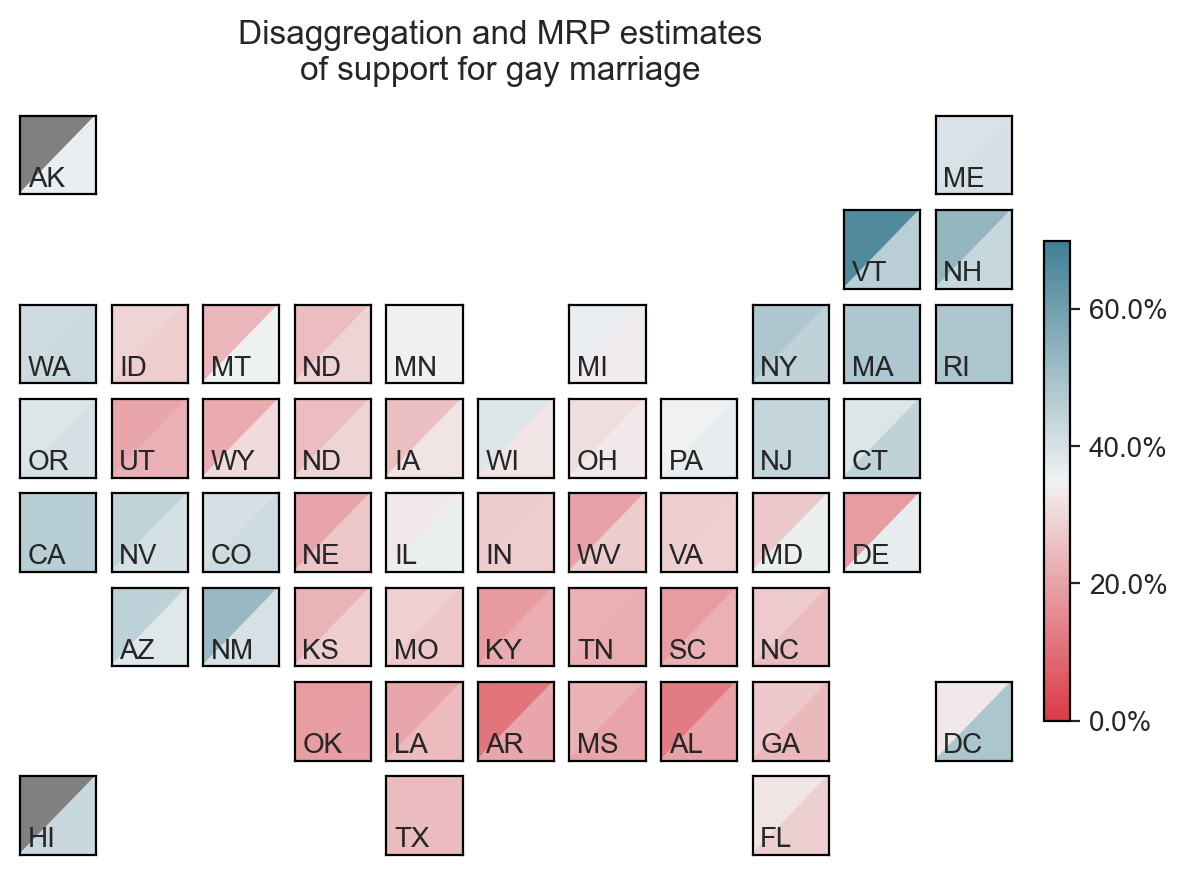

In [56]:
fig, _, cbar_ax = plot_state_grid(
    (
        poll_df.group_by("state").agg(rate("yes_of_all", "poll_pop")),
        poststrat_df,
    ),
    col="yes_of_all",
    norm=PROB_NORM,
    cmap=PROB_CMAP,
    ax_plotter=plot_split_color,
)

make_prob_ax(cbar_ax)
fig.suptitle("Disaggregation and MRP estimates\nof support for gay marriage");

We see that most states support has moved towards the average with the MRP estimate.  Also, MRP produces estimates for Alaska and Hawaii based on their census data, whereas disaggregation cannot.

Finally, we produce another comparison of the two estimates state-by-state.

In [57]:
state_pop = census_df.group_by("state").agg(pl.sum("pop")).sort("state")
state_pop_ = state_pop["pop"].to_numpy().squeeze()

poststrat_state_df = (
    trace.posterior_predictive["response"]
    .rename(response_dim_2="state")
    .assign_coords(state=census_df["state"])
    .groupby("state")
    .sum()
    .pipe(lambda x: x / state_pop_)
)

In [58]:
sorted_states = STATE.categories[
    poststrat_state_df.mean(dim=("chain", "draw")).argsort().to_numpy()
]

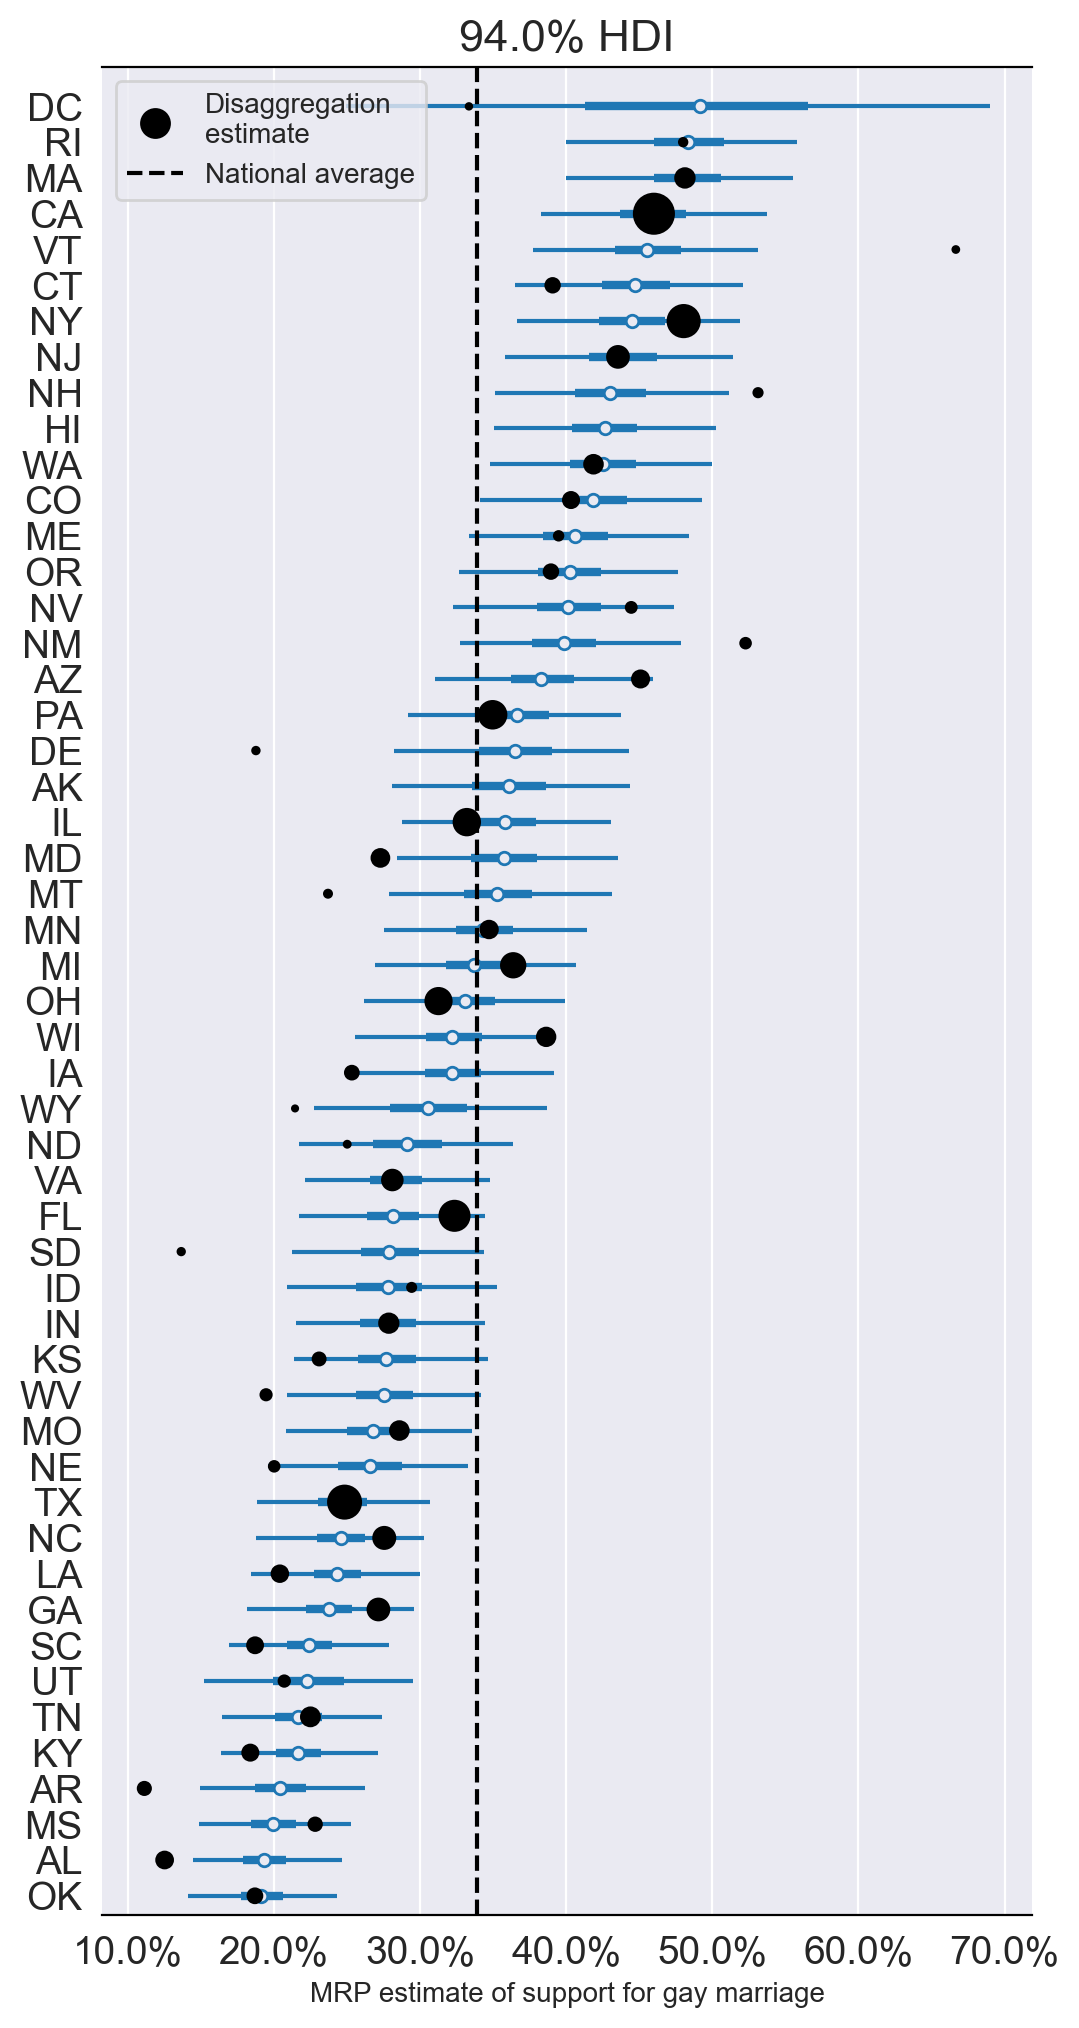

In [59]:
(ax,) = az.plot_forest(
    poststrat_state_df,
    coords={"state": sorted_states[::-1]},
    combined=True,
    labeller=az.labels.NoVarLabeller(),
    figsize=(6, 12),
)

disagg_scatter_df = (
    disagg_df.join(
        pl.DataFrame(
            {
                "state": sorted_states.cast(STATE),
                "sort_key": np.arange(sorted_states.shape[0]),
                "y": ax.get_yticks(),
            }
        ),
        on="state",
    )
    .join(state_pop, on="state")
    .sort("sort_key")
)

pop_norm = Normalize(0, disagg_scatter_df["pop"].max())

ax.scatter(
    disagg_scatter_df["yes_of_all"],
    disagg_scatter_df["y"],
    s=200 * pop_norm(disagg_scatter_df["pop"]),
    c="k",
    label="Disaggregation\nestimate",
    zorder=5,
)

ax.axvline(
    (poststrat_state_df.mean(dim=("chain", "draw")) * state_pop_).sum()
    / state_pop_.sum(),
    ls="--",
    c="k",
    label="National average",
)

ax.xaxis.set_major_formatter(PROB_FORMATTER)
ax.set_xlabel("MRP estimate of support for gay marriage")

ax.legend(loc="upper left");

Here the size of the black circles corresponding to the disaggregation estimate correspond to the state's population.  We see, by and large, that states with higher population have similar disaggregation and MRP estimates, and states with smaller population have MRP estimates closer to the national (disaggregation) mean than their disaggregation estimates.  Notable exceptions to this trend are New York, Florida, and Pennsylvania, among others.  These states's deviation from the trend indicates that the respondent population was particularly unrepresentative of the state's demographics.

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/e160d9687e97fa287ec3a072f6c9865c).

In [60]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sun Nov 23 2025

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.29.0

pymc      : 5.25.1
nutpie    : 0.15.2
us        : 3.2.0
seaborn   : 0.13.2
pytensor  : 2.31.7
arviz     : 0.20.0
polars    : 1.14.0
numpy     : 2.0.2
matplotlib: 3.9.2

